#### Data load

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [5]:
from matplotlib import font_manager

font_path = '../Ruda/Ruda-VariableFont_wght.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [6]:
files = os.listdir('CD_data/08-05-24/')
files_1, files_2, files_3, files_4, files_5 = [], [], [], [], []

for file in files:
    if file[0:2] == '1_' and file[-4:] == '.txt':
        files_1.append(file)
    if file[0:2] == '2_' and file[-4:] == '.txt':
        files_2.append(file)
    if file[0:2] == '3_' and file[-4:] == '.txt':
        files_3.append(file)
    if file[0:2] == '4_' and file[-4:] == '.txt':
        files_4.append(file)
    if file[0:2] == '5_' and file[-4:] == '.txt':
        files_5.append(file)

In [7]:
def smooth(y, box_pts):
    # box = np.ones(box_pts)/box_pts
    # y_smooth = np.convolve(y, box, mode='same')
    
    window_size = 11  # Tamanho da janela (deve ser um número ímpar)
    poly_order = 3    # Ordem do polinômio
    y_smooth = savgol_filter(y, window_size, poly_order)
    
    return y_smooth

In [8]:
def avg_smooth(actual_files,label):
    for i,actual_file in enumerate(actual_files):
        df = pd.read_csv(f'CD_data/08-05-24/{actual_file}',names=['WL','CD Abs'],sep=' ')
        if i == 0:
            cd_abs = list(df['CD Abs'])
        else:
            cd_abs = np.add(cd_abs, list(df['CD Abs']))
    
    cd_abs /= 6

    avg = cd_abs.mean()
    std = cd_abs.std()
    normalized = (cd_abs - avg) / std

    cd_abs = smooth(normalized,5)
    
    return list(df['WL']),cd_abs

#### B1-CBM x BaCBM2

In [23]:
wl,cd_abs_w = avg_smooth(files_1,'Water')
# wl,cd_abs_cbm_50 = avg_smooth(files_2,'CBM_50x')
wl,cd_abs_cbm_100 = avg_smooth(files_3,'CBM_100x')
wl,cd_abs_b1_5 = avg_smooth(files_4,'B1_5x')
# wl,cd_abs_b1 = avg_smooth(files_5,'B1_5x')

In [13]:
cd_abs_cbm_100 = np.subtract(cd_abs_cbm_100[:91],cd_abs_w)
cd_abs_b1_5 = np.subtract(cd_abs_b1_5,cd_abs_w)

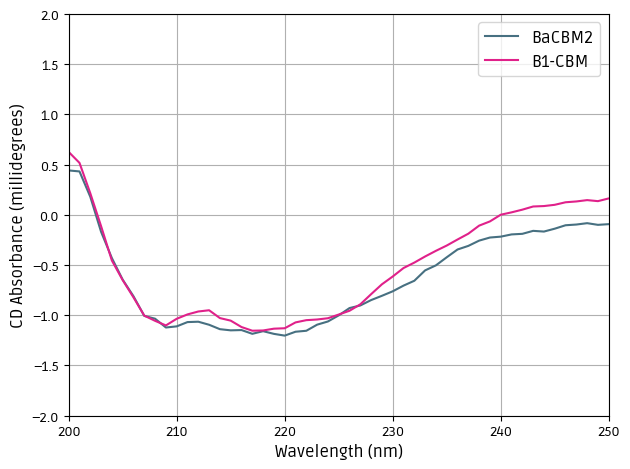

In [14]:
plt.plot(wl,cd_abs_cbm_100,label='BaCBM2',color='#477081')
plt.plot(wl,cd_abs_b1_5,label='B1-CBM',color='#E0218A')

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

plt.xlabel('Wavelength (nm)',fontsize=12)
plt.ylabel('CD Absorbance (millidegrees)',fontsize=12)

plt.xlim(200,250)
plt.ylim(-2,2)


plt.legend(fontsize=12)

plt.grid()

plt.tight_layout()
# plt.savefig('CD_data/results/b1Xcbm.png',dpi=500)

plt.show()

#### Heating Ramp

In [140]:
wl,cd_abs_w = avg_smooth(files_1,'Water')

actual_temp = 20
wls,ramp_plot,temp,error = [],[],[],[]

for i in range(1,97):
    df = pd.read_csv(f'CD_Data/B1-CBM-ramp/1_converted_{i}.txt',names=['WL','CD Abs'],sep=' ')

    if i == 1:
        cd_abs_actual = list(df['CD Abs'])
    

    if i % 6 == 0:
        actual_temp += 5
        cd_abs_actual = list(df['CD Abs'])
    else:
        cd_abs_actual = np.add(list(df['CD Abs']),cd_abs_actual)

    if i % 6 == 0:
        
        cd_abs_actual = [x/6 for x in cd_abs_actual]
        cd_abs_actual = np.array(cd_abs_actual)

        cd_abs_actual = np.subtract(cd_abs_actual,cd_abs_w[20:])

        avg = cd_abs_actual.mean()
        std = cd_abs_actual.std()
        normalized = (cd_abs_actual - avg) / std

        standard_error = std / np.sqrt(len(cd_abs_actual))
        error.append(standard_error)

        cd_abs_actual = smooth(normalized,5)

        temp.append(actual_temp)
        ramp_plot.append(cd_abs_actual)
        wls.append(list(df['WL']))

In [141]:
valores_wl = np.array(wls)
valores_cd = np.array(ramp_plot)
temperaturas = np.array(temp)

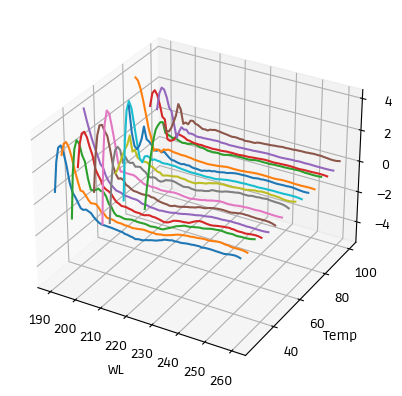

In [142]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotando os pontos
for i in range(len(temperaturas)):
    ax.plot(valores_wl[i], temperaturas[i] * np.ones_like(valores_wl[i]), valores_cd[i])

# Adicionando labels
ax.set_xlabel('WL')
ax.set_ylabel('Temp')
ax.set_zlabel('CD')

plt.show()

In [143]:
X_b1, Y_b1 = np.meshgrid(valores_wl[0], temperaturas)
Z_b1 = np.array([valores_cd[i] for i in range(len(temperaturas))])

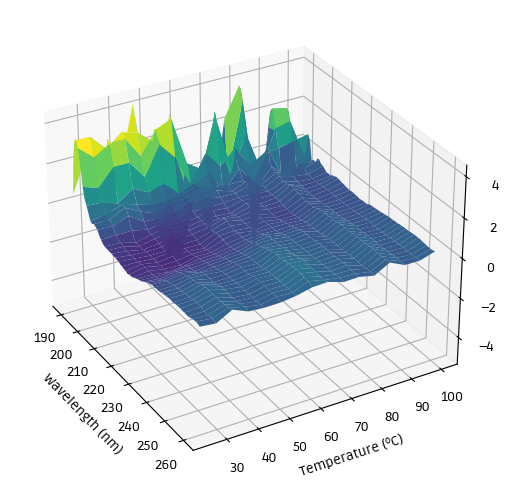

In [144]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_b1, Y_b1, Z_b1, cmap='viridis')

ax.set_ylabel('Temp')

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Temperature (ºC)')
ax.set_zlabel('CD Absorbance (millidegrees)')

ax.view_init(30,-30)

plt.tight_layout()

plt.show()

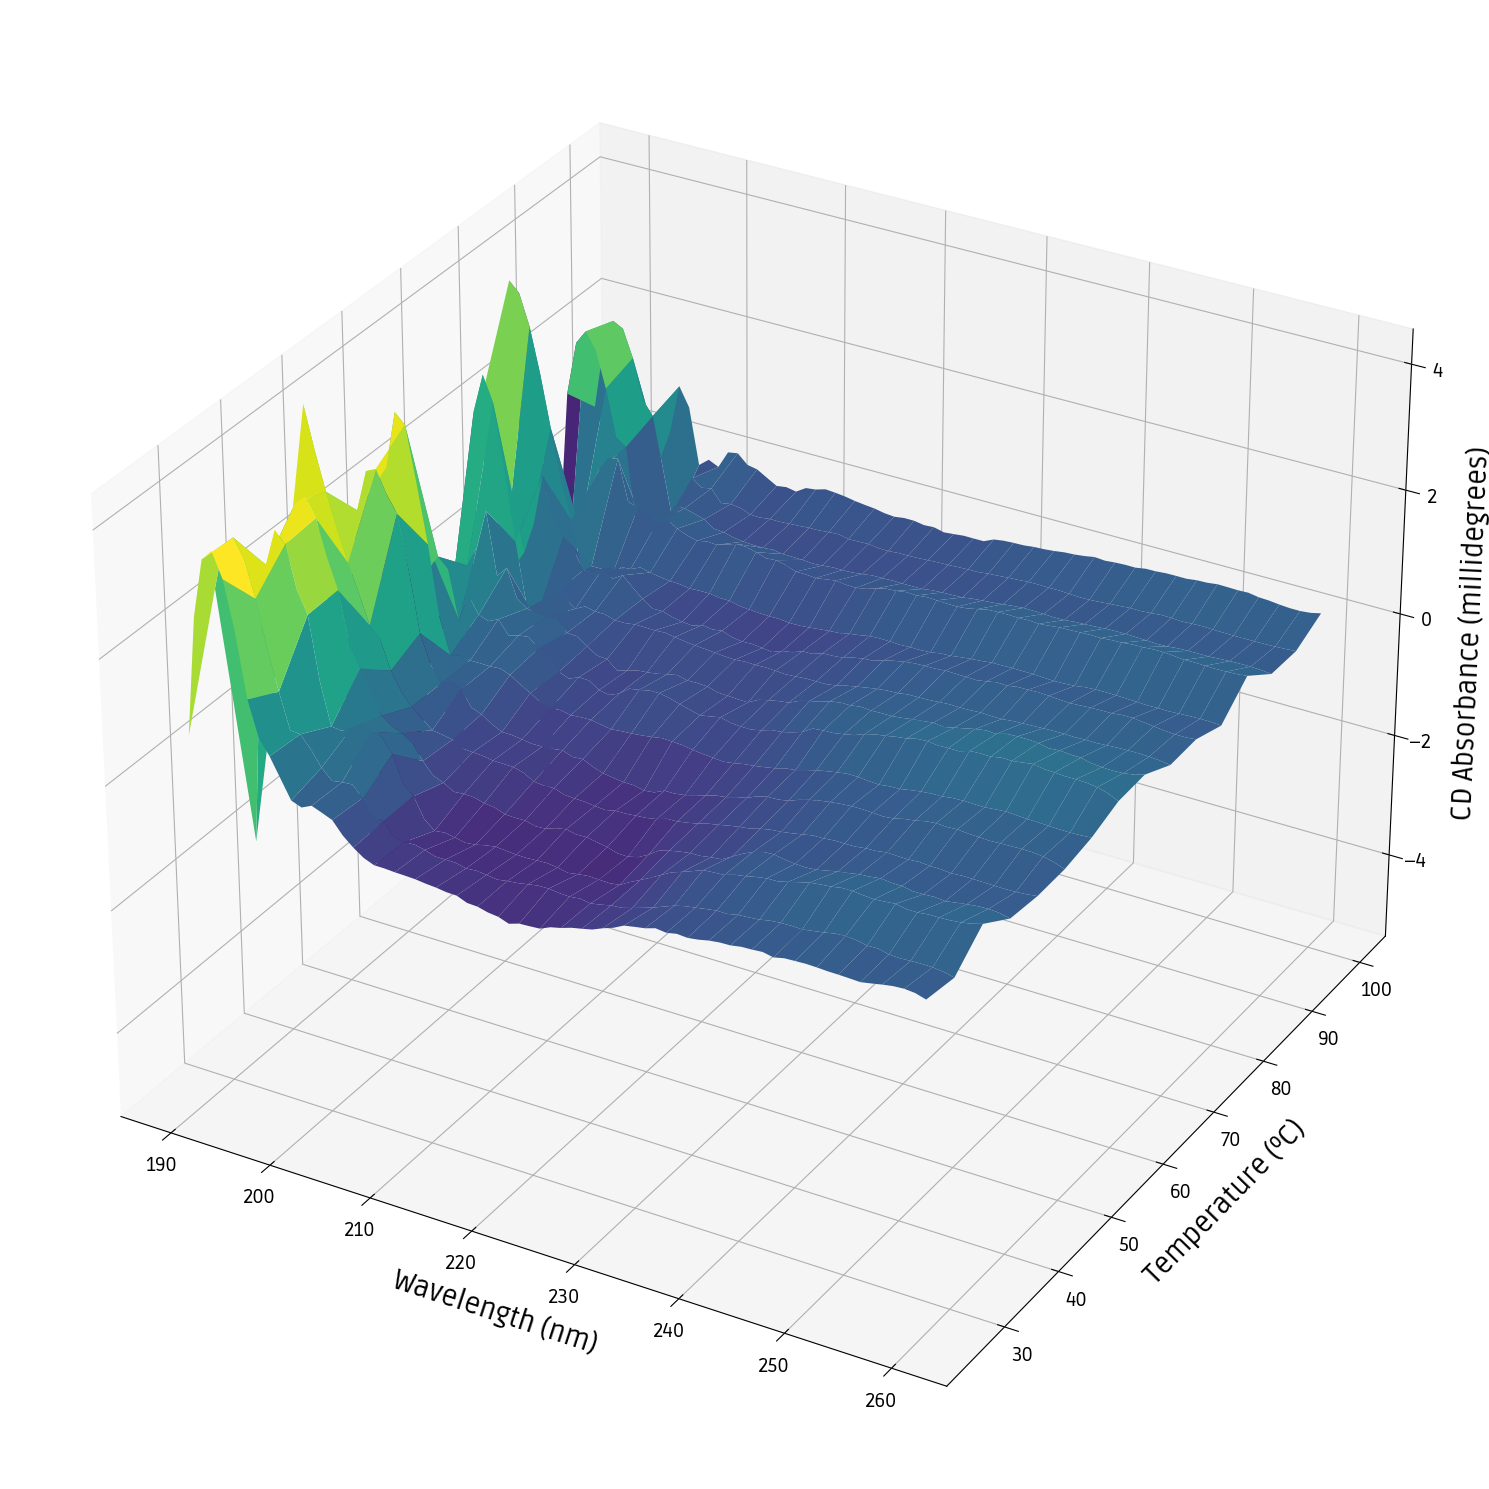

In [145]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_b1, Y_b1, Z_b1, cmap='viridis')

ax.set_ylabel('Temp')

ax.set_xlabel('\nWavelength (nm)',fontsize=20)
ax.set_ylabel('\nTemperature (ºC)',fontsize=20)
ax.set_zlabel('\nCD Absorbance (millidegrees)',fontsize=20)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='z', labelsize=14)

# ax.view_init(5,0)

plt.tight_layout()
# plt.savefig('CD_data/results/b1_ramp.png',dpi=300)

plt.show()

C:\Users\pedro220068\AppData\Local\Temp\ipykernel_152284\1280477651.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(temperaturas, cd_215, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")


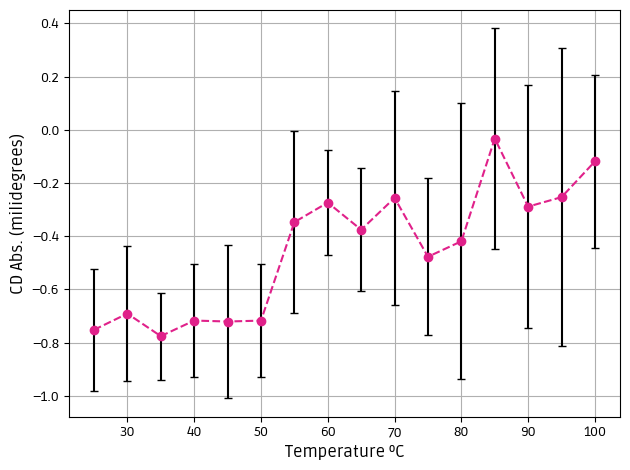

In [146]:
cd_215 = []
for i in range(len(valores_cd)):
    cd_215.append(valores_cd[i][41])

plt.errorbar(temperaturas, cd_215, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")

plt.xlabel('Temperature ºC',fontsize=12)
plt.ylabel('CD Abs. (milidegrees)',fontsize=12)

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.grid()
# plt.savefig('CD_data/results/b1_ramp_215nm.png',dpi=300)

plt.show()

In [147]:
wl,cd_abs_w = avg_smooth(files_1,'Water')

actual_temp = 20
wls,ramp_plot,temp,error = [],[],[],[]

for i in range(1,97):
    df = pd.read_csv(f'CD_Data/BaCBM2-ramp/1_converted_{i}.txt',names=['WL','CD Abs'],sep=' ')

    if i == 1:
        cd_abs_actual = list(df['CD Abs'])
    

    if i % 6 == 0:
        actual_temp += 5
        cd_abs_actual = list(df['CD Abs'])
    else:
        cd_abs_actual = np.add(list(df['CD Abs']),cd_abs_actual)

    if i % 6 == 0:
        
        cd_abs_actual = [x/6 for x in cd_abs_actual]
        cd_abs_actual = np.array(cd_abs_actual)

        cd_abs_actual = np.subtract(cd_abs_actual,cd_abs_w[20:])

        avg = cd_abs_actual.mean()
        std = cd_abs_actual.std()
        normalized = (cd_abs_actual - avg) / std

        standard_error = std / np.sqrt(len(cd_abs_actual))
        error.append(standard_error)

        cd_abs_actual = smooth(normalized,5)

        temp.append(actual_temp)
        ramp_plot.append(cd_abs_actual)
        wls.append(list(df['WL']))

valores_wl = np.array(wls)
valores_cd = np.array(ramp_plot)
temperaturas = np.array(temp)

In [148]:
X_cbm, Y_cbm = np.meshgrid(valores_wl[0], temperaturas)
Z_cbm = np.array([valores_cd[i] for i in range(len(temperaturas))])

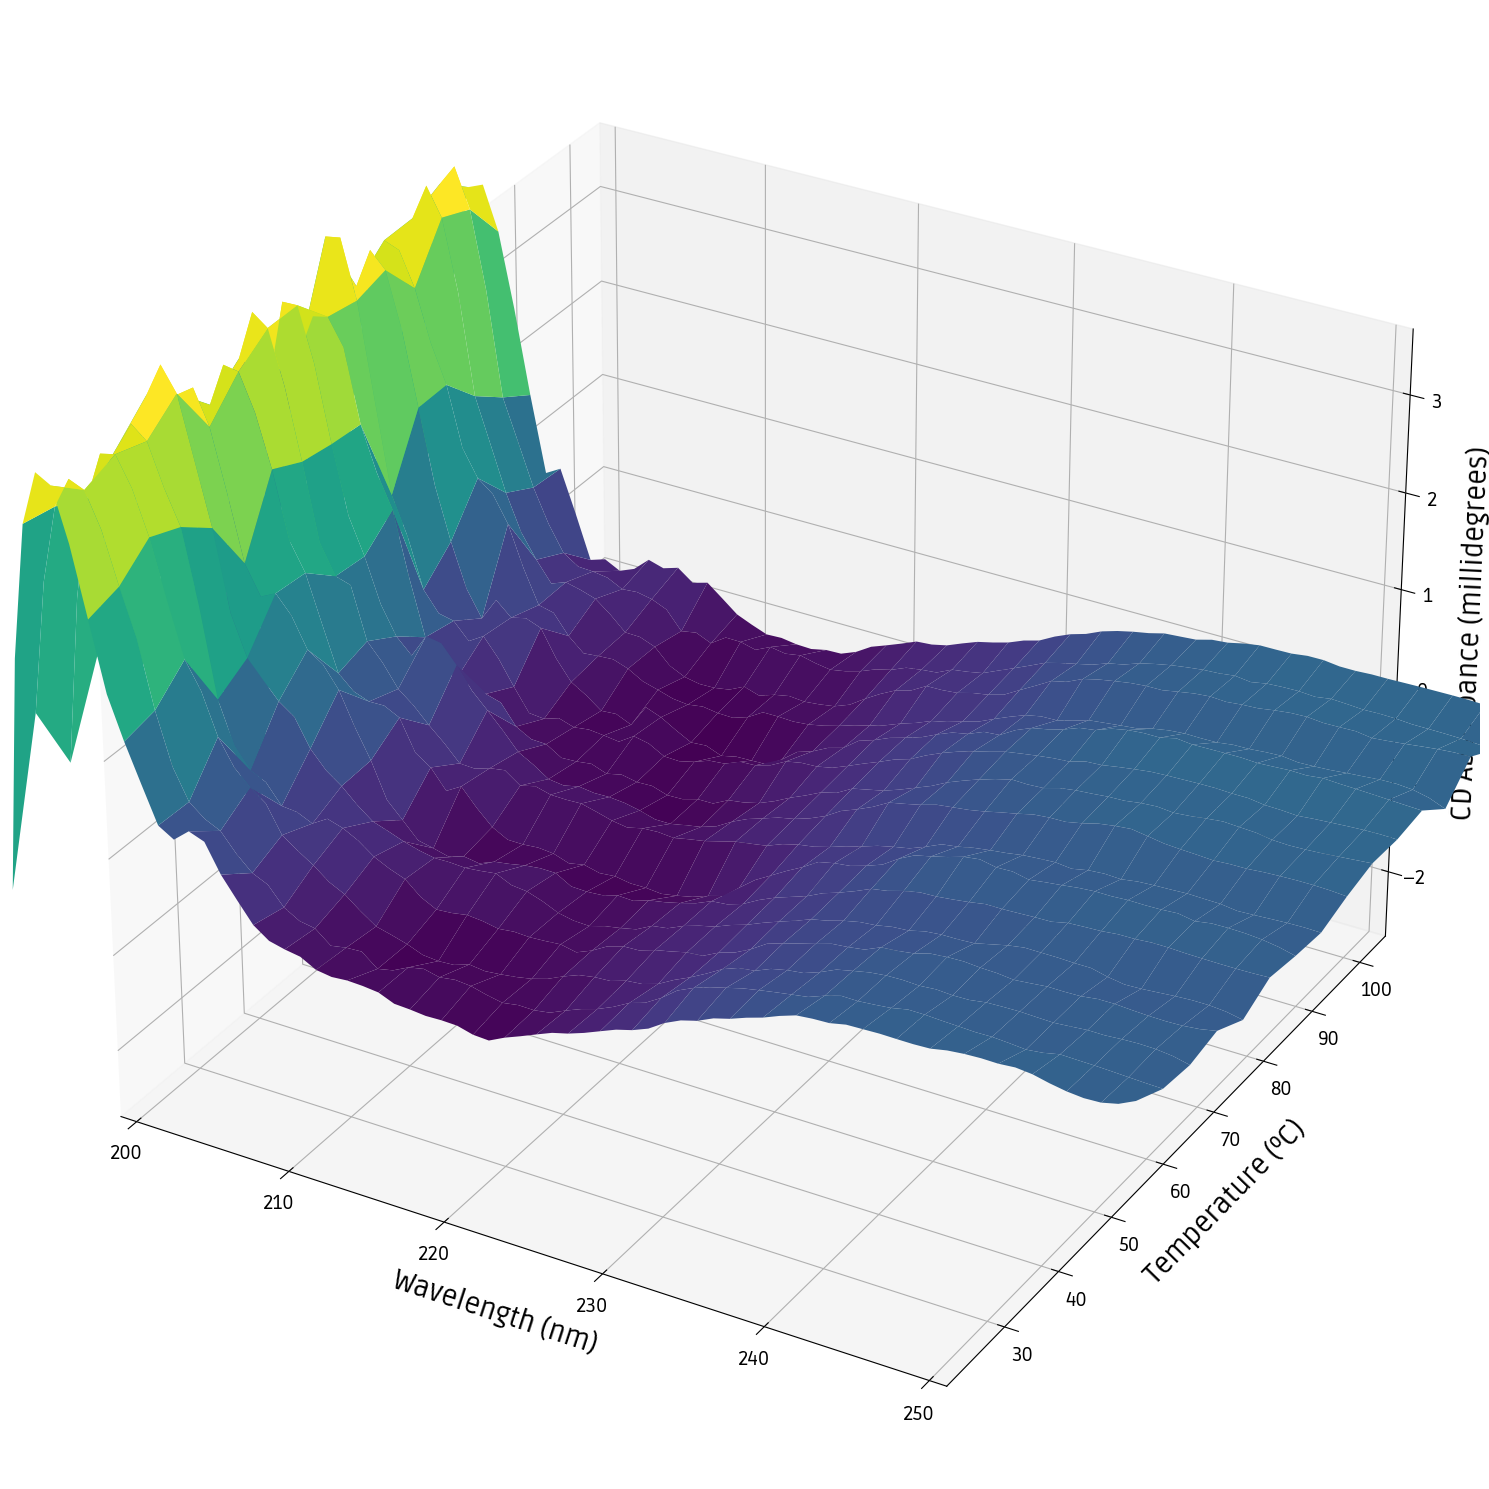

In [163]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_cbm, Y_cbm, Z_cbm, cmap='viridis')

ax.set_ylabel('Temp')

ax.set_xlabel('\nWavelength (nm)',fontsize=20)
ax.set_ylabel('\nTemperature (ºC)',fontsize=20)
ax.set_zlabel('\nCD Absorbance (millidegrees)',fontsize=20)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='z', labelsize=14)

plt.xlim(200,250)

# ax.view_init(5,0)

plt.tight_layout()
# plt.savefig('CD_data/results/cbm_ramp.png',dpi=300)

plt.show()

C:\Users\pedro220068\AppData\Local\Temp\ipykernel_152284\171938850.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(temperaturas, cd_215, yerr=error, capsize=3, fmt="r--o", color="#477081", ecolor = "black")


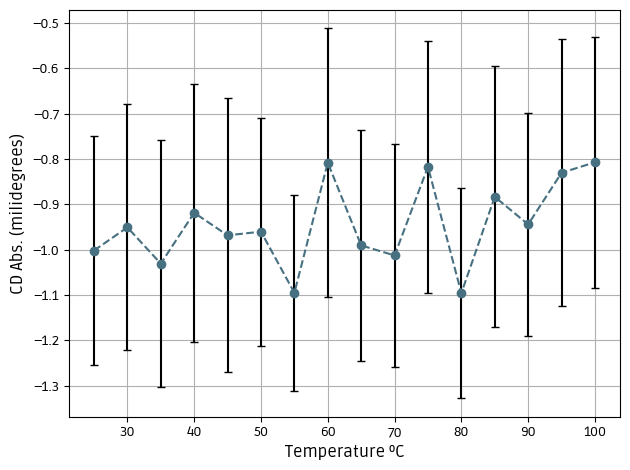

In [150]:
cd_215 = []
for i in range(len(valores_cd)):
    cd_215.append(valores_cd[i][41])

plt.errorbar(temperaturas, cd_215, yerr=error, capsize=3, fmt="r--o", color="#477081", ecolor = "black")

plt.xlabel('Temperature ºC',fontsize=12)
plt.ylabel('CD Abs. (milidegrees)',fontsize=12)

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

plt.grid()
plt.tight_layout()
# plt.savefig('CD_data/results/cbm_ramp_215nm.png',dpi=300)

plt.show()

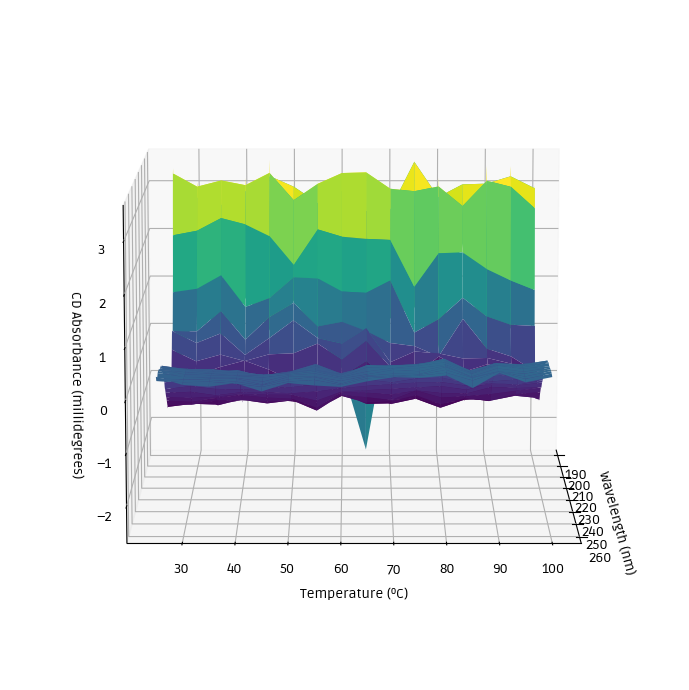

In [151]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_cbm, Y_cbm, Z_cbm, cmap='viridis')

ax.set_ylabel('Temp')

ax.set_xlabel('Wavelength (nm)\n')
ax.set_ylabel('\nTemperature (ºC)')
ax.set_zlabel('CD Absorbance (millidegrees)')

ax.view_init(10,0)

plt.tight_layout()
# plt.savefig('CD_data/results/cbm_ramp_sideview.png',dpi=300)

plt.show()

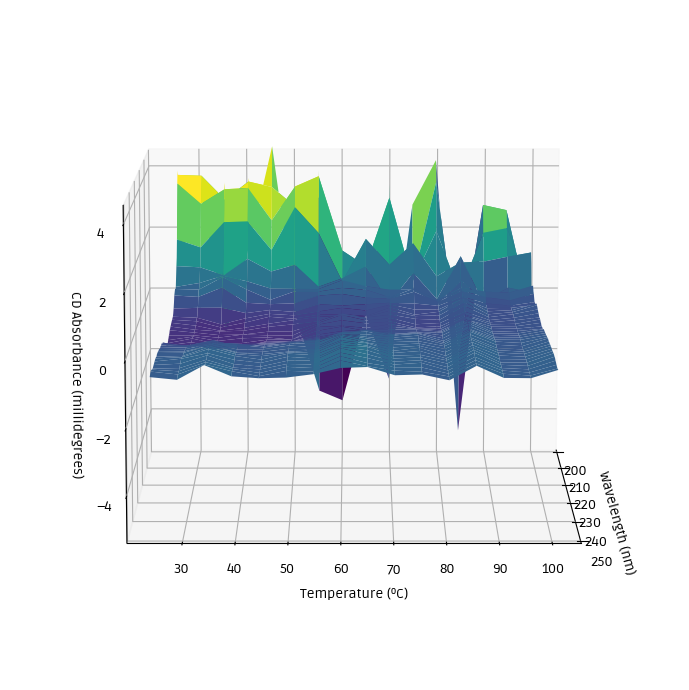

In [162]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_b1, Y_b1, Z_b1, cmap='viridis')

ax.set_ylabel('Temp')

ax.set_xlabel('Wavelength (nm)\n')
ax.set_ylabel('\nTemperature (ºC)')
ax.set_zlabel('CD Absorbance (millidegrees)')

ax.view_init(10,0)

plt.xlim(200,250)
plt.tight_layout()
# plt.savefig('CD_data/results/b1_ramp_sideview.png',dpi=300)

plt.show()

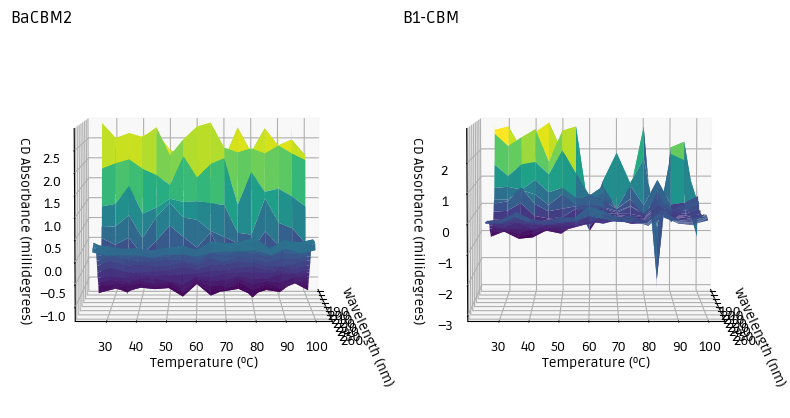

In [22]:
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot_surface(X_cbm, Y_cbm, Z_cbm, cmap='viridis')
ax1.set_title('BaCBM2',loc='left')
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Temperature (ºC)')
ax1.set_zlabel('CD Absorbance (millidegrees)')
ax1.view_init(5, 0)

ax2.plot_surface(X_b1, Y_b1, Z_b1, cmap='viridis')
ax2.set_title('B1-CBM',loc='left')
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Temperature (ºC)')
ax2.set_zlabel('CD Absorbance (millidegrees)')
ax2.view_init(5, 0)

plt.tight_layout()
plt.show()

#### Plastic Interaction

001 - Water- Pathway 1 mm Mickey Cell

002 - NPL 100 nm - 0.005 g.mL - dilluted 10x from stock solution 200x

003 - NPL 100 nm - 0.0005 g.mL - dilluted 10x from previous solution 0.005 g.mL

004 - CBM 100x dilluted

005 - CBM 100x dilluted + NPL 100 nm - add 30 uL from stock solution 200x - final plastic 0.0005 g.mL

006 - Barbie1 5x dilluted

007 - Barbie1 5x dilluted + NPL 100 nm - add 30 uL from stock solution 200x - final plastic 0.0005 g.mL

008 - Background Barbie 1 - Buffer 5x dilluted

009 - CBM 50x dilluted

In [23]:
def data_proccess(i):
    for k in range(1,7):
        df = pd.read_csv(f'CD_Data/08-07-24/{i}_converted_{k}.txt',names=['WL','CD Abs'],sep=' ')
        
        if k == 1:
            cd_abs = list(df['CD Abs'])
        else:
            cd_abs = np.add(cd_abs,list(df['CD Abs']))
        
    cd_abs = [x/6 for x in cd_abs]

    cd_abs_actual = np.array(cd_abs)
    avg = cd_abs_actual.mean()
    std = cd_abs_actual.std()
    normalized = (cd_abs_actual - avg) / std

    cd_abs_actual = smooth(normalized,5)

    return list(df['WL']), cd_abs_actual

In [24]:
# CBM + NPL (5-3-1)
# B1 + NPL (8-3-1)

wl, cd_abs_w = data_proccess(1)
_, cd_abs_npl = data_proccess(3)
_, cd_abs_cbm = data_proccess(4)
_, cd_abs_cbm_np = data_proccess(5)
_, cd_abs_b1 = data_proccess(6)
_, cd_abs_b1_np = data_proccess(7)

In [25]:
# cd_abs_cbm = np.subtract(cd_abs_cbm,cd_abs_w)
# cd_abs_b1 = np.subtract(cd_abs_b1,cd_abs_w)

cd_abs_cbm_c = np.subtract(cd_abs_cbm_np,cd_abs_npl)
# cd_abs_cbm_c = np.subtract(cd_abs_cbm_c,cd_abs_w)

cd_abs_b1_c = np.subtract(cd_abs_b1_np,cd_abs_npl)
# cd_abs_b1_c = np.subtract(cd_abs_b1_c,cd_abs_w)

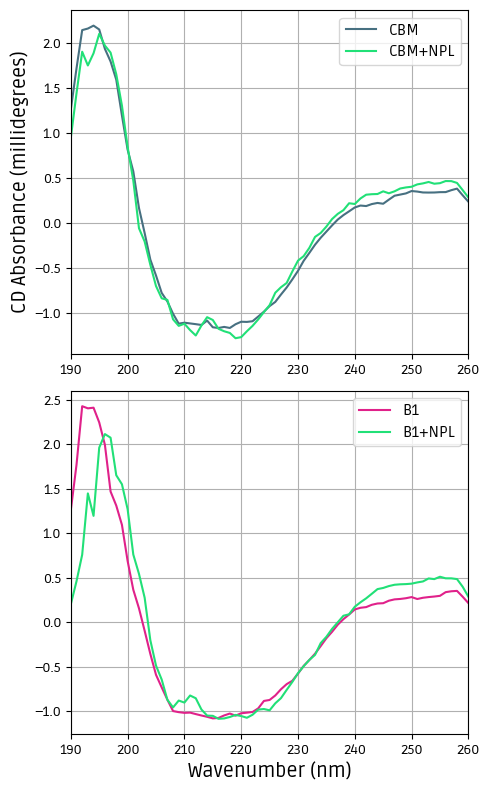

In [26]:
plt.figure(figsize=(5,8))

plt.subplot(211)

plt.plot(_,cd_abs_cbm,label='CBM',color='#477081')
plt.plot(_,cd_abs_cbm_np,label='CBM+NPL',color='#21E077')

# plt.plot(_, cd_abs_npl)

# plt.plot(wl,cd_abs_cbm)

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

plt.grid()

# plt.xlabel('Temperature (ºC)',fontsize=14)
plt.ylabel('CD Absorbance (millidegrees)',fontsize=14)

plt.xlim(min(wl),max(wl))

plt.legend(fontsize=11)

plt.subplot(212)

plt.plot(_,cd_abs_b1,label='B1',color='#E0218A')
plt.plot(_,cd_abs_b1_np,label='B1+NPL',color='#21E077')

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

plt.grid()

plt.xlabel('Wavenumber (nm)',fontsize=14)

plt.xlim(min(wl),max(wl))

plt.legend(fontsize=11)

plt.tight_layout()
# plt.savefig('CD_data/results/proteins_NPL.png',dpi=300)

plt.show()

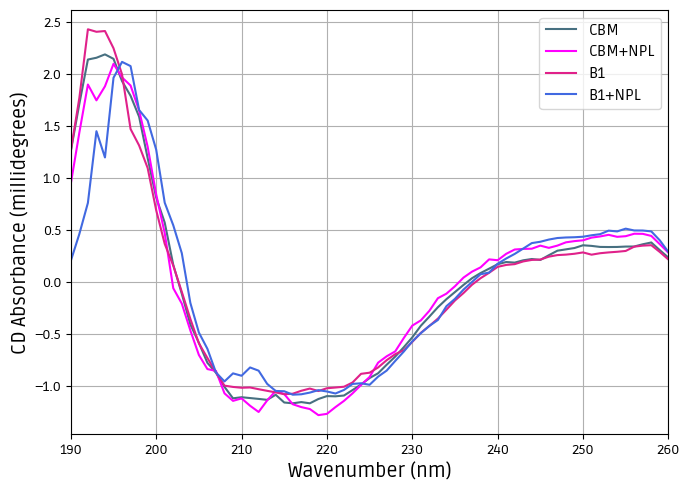

In [27]:
plt.figure(figsize=(7,5))

plt.plot(wl,cd_abs_cbm,label='CBM',color='#477081')
plt.plot(wl,cd_abs_cbm_np,label='CBM+NPL',color='magenta')
# plt.plot(wl,cd_abs_cbm)

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

plt.xlabel('Temperature (ºC)',fontsize=14)
plt.ylabel('CD Absorbance (millidegrees)',fontsize=14)

plt.plot(wl,cd_abs_b1,label='B1',color='#E0218A')
plt.plot(wl,cd_abs_b1_np,label='B1+NPL',color='royalblue')

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

plt.xlabel('Wavenumber (nm)',fontsize=14)

plt.xlim(min(wl),max(wl))

plt.legend(fontsize=11)

plt.tight_layout()
plt.grid()
# plt.savefig('CD_data/results/joined_proteins_NPL.png',dpi=300)

plt.show()

#### Pontual Specta

In [28]:
cbm_pontual = pd.read_csv('CD_data/pontual_spectra/CBM/pontual CBM.asc',sep='\t',names=['Temperature','CD Absorbance'])
b1_pontual = pd.read_csv('CD_data/pontual_spectra/Barbie1/pontual B1.asc',sep='\t',names=['Temperature','CD Absorbance'])

In [30]:
def norm_smooth(cd_abs_data):
    avg = cd_abs_data.mean()
    std = cd_abs_data.std()
    normalized = (cd_abs_data - avg) / std

    cd_abs_data = smooth(normalized,5)
    return cd_abs_data

In [31]:
# cbm_pontual_abs = norm_smooth(cbm_pontual['CD Absorbance'])
# b1_pontual_abs = norm_smooth(b1_pontual['CD Absorbance'])

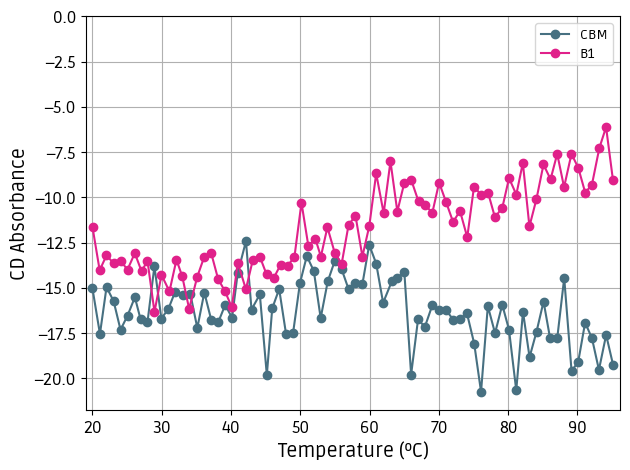

In [32]:
# plt.plot(cbm_pontual['Temperature'],cbm_pontual_abs,'-o',label='CBM',color='#477081')
# plt.plot(b1_pontual['Temperature'],b1_pontual_abs,'-o',label='CBM',color='#E0218A')

plt.plot(cbm_pontual['Temperature'],cbm_pontual['CD Absorbance'],'-o',label='CBM',color='#477081')
plt.plot(b1_pontual['Temperature'],b1_pontual['CD Absorbance'],'-o',label='B1',color='#E0218A')

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

# plt.title('Pontual Spectra',loc='left')
plt.xlabel('Temperature (ºC)',fontsize=14)
plt.ylabel('CD Absorbance',fontsize=14)

plt.xlim(min(cbm_pontual['Temperature'])-1,max(cbm_pontual['Temperature'])+1)
plt.ylim(min(cbm_pontual['CD Absorbance'])-1,0)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend()
plt.grid()
plt.tight_layout()

# plt.savefig('CD_data/results/pontual_spectra.png',dpi=300)

plt.show()

#### Heating-Cooling Ramp

In [328]:
def rampplot(caminho,temp_min,temp_max,water=False):
    
    actual_temp = temp_min
    wls,ramp_plot,temp,error = [],[],[],[]

    for i in range(1,int(6*(temp_max-temp_min)/5)+1):
        
        df = pd.read_csv(f'{caminho}/1_converted_{i}.txt',names=['WL','CD Abs'],sep=' ')

        if i % 6 == 0 and i != 1:
                        
            cd_abs_actual = [x/6 for x in cd_abs_actual]
            cd_abs_actual = np.array(cd_abs_actual)

            if water:
                # Read Water Before!
                cd_abs_actual = np.subtract(cd_abs_actual,cd_abs_w[30:])

            avg = cd_abs_actual.mean()
            std = cd_abs_actual.std()
            normalized = (cd_abs_actual - avg) / std
            standard_error = std / np.sqrt(len(cd_abs_actual))

            wls.append(list(df['WL']))
            temp.append(actual_temp)
            ramp_plot.append(cd_abs_actual)
            error.append(standard_error)

            actual_temp += 5

        if i % 6 == 0 or i == 1: cd_abs_actual = list(df['CD Abs'])
        else: cd_abs_actual += list(df['CD Abs'])

    return wls, temp, ramp_plot, error

In [326]:
rampplot('CD_data/B1-CBM-ramp',20,100)

#### Trash

In [346]:
wl,cd_abs_w = avg_smooth(files_1,'Water')

actual_temp = 20
wls,ramp_plot,temp,error = [],[],[],[]

for i in range(1,96):
    df = pd.read_csv(f'CD_Data/rampa B1_05_09/1_converted_{i}.txt',names=['WL','CD Abs'],sep=' ')

    if i % 6 == 0:
        actual_temp += 5
        cd_abs_actual = list(df['CD Abs'])
    else:
        cd_abs_actual = np.add(list(df['CD Abs']),cd_abs_actual)

    if i % 6 == 0 and i != 1:
        
        cd_abs_actual = [x/6 for x in cd_abs_actual]
        cd_abs_actual = np.array(cd_abs_actual)

        # cd_abs_actual = np.subtract(cd_abs_actual,cd_abs_w[30:])

        avg = cd_abs_actual.mean()
        std = cd_abs_actual.std()
        normalized = (cd_abs_actual - avg) / std

        standard_error = std / np.sqrt(len(cd_abs_actual))
        error.append(standard_error)

        # cd_abs_actual = smooth(normalized,5)
        # cd_abs_actual = smooth(cd_abs_actual,5)

        temp.append(actual_temp)
        ramp_plot.append(cd_abs_actual)
        wls.append(list(df['WL']))

In [350]:
print(len(wls[0]), len(temp), len(ramp_plot), len(error))

61 15 15 15


In [342]:
cd_abs_heat = cd_abs_actual.copy()

In [343]:
valores_wl = np.array(wls)
valores_cd = np.array(ramp_plot)
temperaturas = np.array(temp)

In [293]:
valores_wl[0][40],valores_wl[0][28]

(210.0, 222.0)

C:\Users\pedro220068\AppData\Local\Temp\ipykernel_25700\750211575.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(temperaturas, cd_210_heat, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")


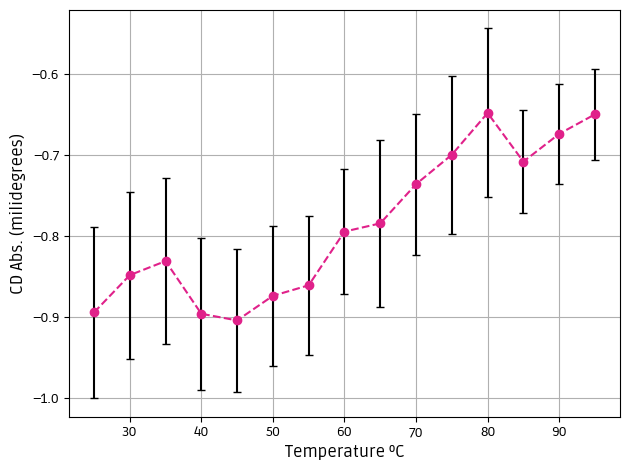

In [294]:
cd_210_heat = []
for i in range(len(valores_cd)):
    cd_210_heat.append(valores_cd[i][40])

plt.errorbar(temperaturas, cd_210_heat, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")

plt.xlabel('Temperature ºC',fontsize=12)
plt.ylabel('CD Abs. (milidegrees)',fontsize=12)

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.grid()
# plt.savefig('CD_data/results/b1_ramp_215nm.png',dpi=300)

plt.show()

C:\Users\pedro220068\AppData\Local\Temp\ipykernel_25700\3577951961.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(temperaturas, cd_222_heat, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")


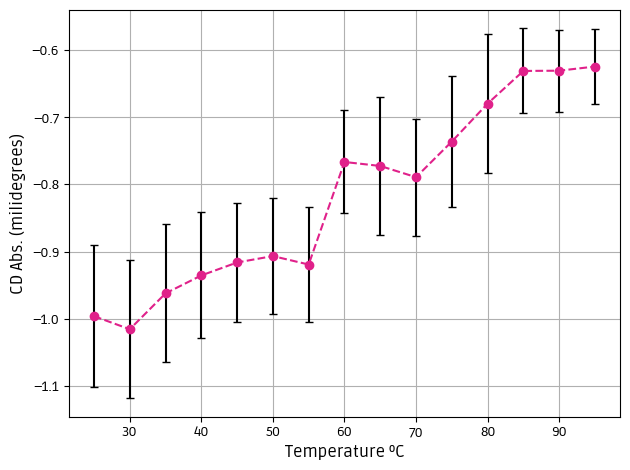

In [295]:
cd_222_heat = []
for i in range(len(valores_cd)):
    cd_222_heat.append(valores_cd[i][28])

plt.errorbar(temperaturas, cd_222_heat, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")

plt.xlabel('Temperature ºC',fontsize=12)
plt.ylabel('CD Abs. (milidegrees)',fontsize=12)

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.grid()
# plt.savefig('CD_data/results/b1_ramp_215nm.png',dpi=300)

plt.show()

In [344]:
X_b1, Y_b1 = np.meshgrid(valores_wl[0], temperaturas)
Z_b1 = np.array([valores_cd[i] for i in range(len(temperaturas))])

In [352]:
valores_cd.shape

(15, 61)

In [297]:
X_b1_heat, Y_b1_heat = np.meshgrid(valores_wl[0], temperaturas)
Z_b1_heat = np.array([valores_cd[i] for i in range(len(temperaturas))])

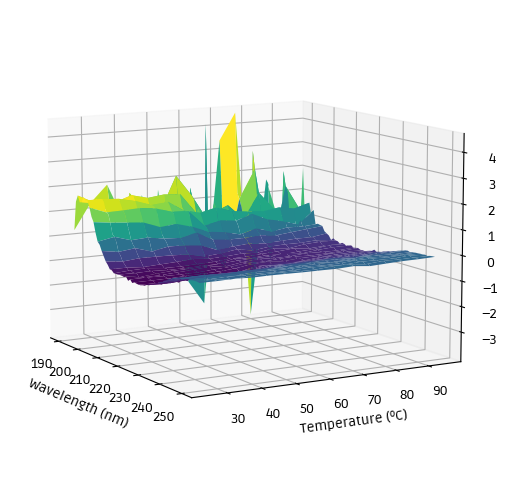

In [345]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_b1, Y_b1, Z_b1, cmap='viridis')

ax.set_ylabel('Temp')

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Temperature (ºC)')
ax.set_zlabel('CD Absorbance (millidegrees)')

ax.view_init(10,-30)

plt.tight_layout()

plt.show()

In [280]:
wl,cd_abs_w = avg_smooth(files_1,'Water')

actual_temp = 20
wls,ramp_plot,temp,error = [],[],[],[]

for i in range(96,186):
    df = pd.read_csv(f'CD_Data/rampa B1_05_09/1_converted_{i}.txt',names=['WL','CD Abs'],sep=' ')

    if i == 96:
        cd_abs_actual = list(df['CD Abs'])
    

    if i % 6 == 0:
        actual_temp += 5
        cd_abs_actual = list(df['CD Abs'])
    else:
        cd_abs_actual = np.add(list(df['CD Abs']),cd_abs_actual)

    if i % 6 == 0:
        
        cd_abs_actual = [x/6 for x in cd_abs_actual]
        cd_abs_actual = np.array(cd_abs_actual)

        # cd_abs_actual = np.subtract(cd_abs_actual,cd_abs_w[30:])

        avg = cd_abs_actual.mean()
        std = cd_abs_actual.std()
        normalized = (cd_abs_actual - avg) / std

        standard_error = std / np.sqrt(len(cd_abs_actual))
        error.append(standard_error)

        # cd_abs_actual = smooth(normalized,5)
        cd_abs_actual = smooth(cd_abs_actual,5)

        temp.append(actual_temp)
        ramp_plot.append(cd_abs_actual)
        wls.append(list(df['WL']))

In [281]:
cd_abs_cool = cd_abs_actual.copy()

In [282]:
valores_wl = np.array(wls)
valores_cd = np.array(ramp_plot)
temperaturas = np.array(temp)

In [283]:
X_b1, Y_b1 = np.meshgrid(valores_wl[0], temperaturas)
Z_b1 = np.array([valores_cd[i] for i in range(len(temperaturas))])

In [284]:
X_b1_cool, Y_b1_cool = np.meshgrid(valores_wl[0], temperaturas)
Z_b1_cool = np.array([valores_cd[i] for i in range(len(temperaturas))])

C:\Users\pedro220068\AppData\Local\Temp\ipykernel_25700\897697551.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(temperaturas, cd_210_cool, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")


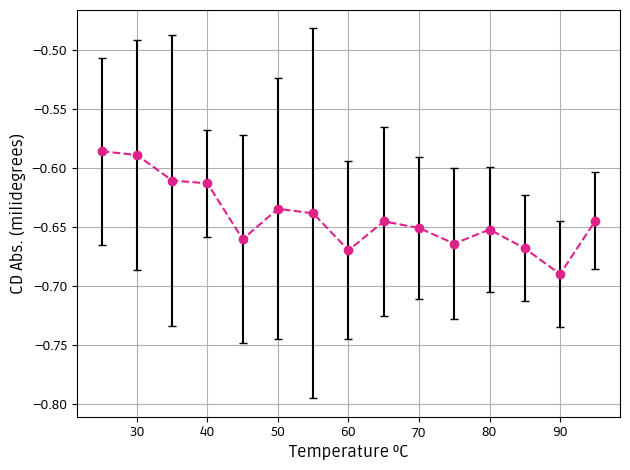

In [285]:
cd_210_cool = []
for i in range(len(valores_cd)):
    cd_210_cool.append(valores_cd[i][41])

plt.errorbar(temperaturas, cd_210_cool, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")

plt.xlabel('Temperature ºC',fontsize=12)
plt.ylabel('CD Abs. (milidegrees)',fontsize=12)

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.grid()
# plt.savefig('CD_data/results/b1_ramp_215nm.png',dpi=300)

plt.show()

C:\Users\pedro220068\AppData\Local\Temp\ipykernel_25700\2138391060.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(temperaturas, cd_222_cool, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")


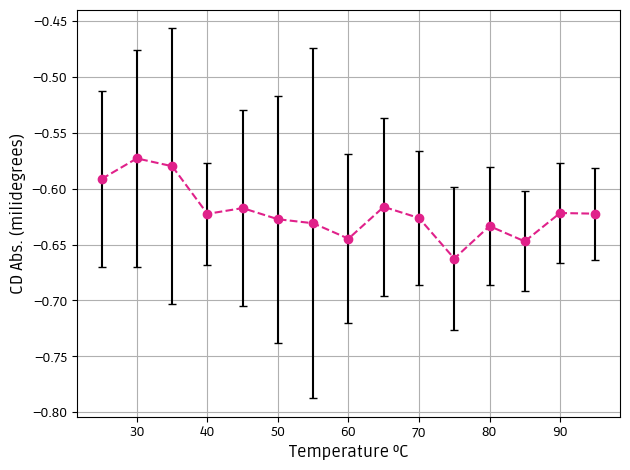

In [286]:
cd_222_cool = []
for i in range(len(valores_cd)):
    cd_222_cool.append(valores_cd[i][28])

plt.errorbar(temperaturas, cd_222_cool, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")

plt.xlabel('Temperature ºC',fontsize=12)
plt.ylabel('CD Abs. (milidegrees)',fontsize=12)

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.grid()
# plt.savefig('CD_data/results/b1_ramp_215nm.png',dpi=300)

plt.show()

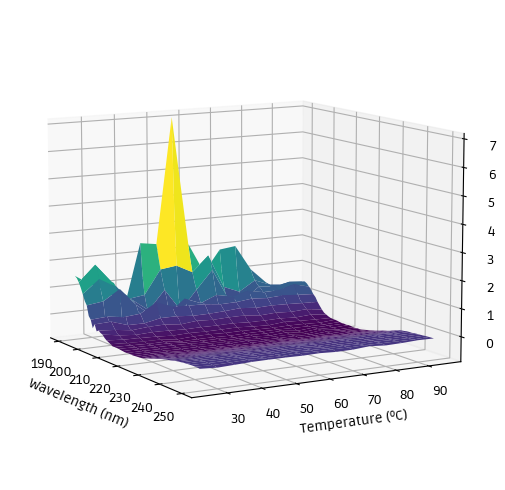

In [287]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_b1, Y_b1, Z_b1, cmap='viridis')

ax.set_ylabel('Temp')

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Temperature (ºC)')
ax.set_zlabel('CD Absorbance (millidegrees)')

ax.view_init(10,-30)

plt.tight_layout()

plt.show()

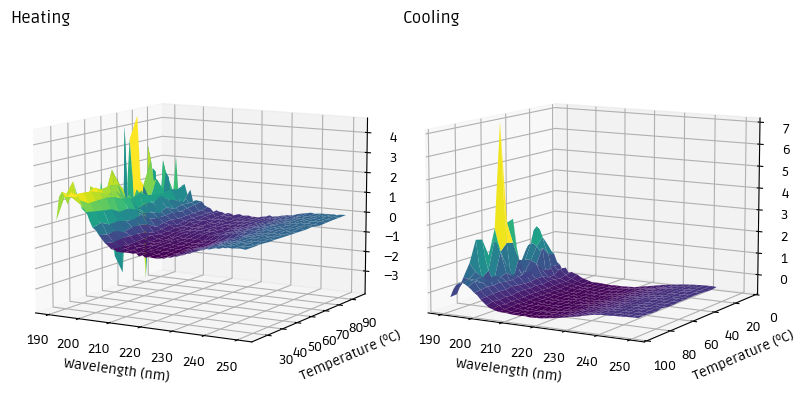

In [288]:
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot_surface(X_b1_heat, Y_b1_heat, Z_b1_heat, cmap='viridis')
ax1.set_title('Heating',loc='left')
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Temperature (ºC)')
ax1.set_zlabel('CD Absorbance (millidegrees)')
ax1.view_init(10, -60)

ax2.plot_surface(X_b1_cool, Y_b1_cool, Z_b1_cool, cmap='viridis')
ax2.set_title('Cooling',loc='left')
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Temperature (ºC)')
ax2.set_zlabel('CD Absorbance (millidegrees)')
ax2.view_init(10, -60)

ax2.set_ylim(100,0)

plt.tight_layout()
plt.show()

In [250]:
def data_proccess(i):
    for k in range(1,7):
        # df = pd.read_csv(f'CD_Data/spectrum B1/{i}_converted_{k}.txt',names=['WL','CD Abs'],sep=' ')
        df = pd.read_csv(f'CD_Data/spectrum B1 apos rampa/{i}_converted_{k}.txt',names=['WL','CD Abs'],sep=' ')
        
        if k == 1:
            cd_abs = list(df['CD Abs'])
        else:
            cd_abs = np.add(cd_abs,list(df['CD Abs']))
        
    cd_abs = [x/6 for x in cd_abs]

    cd_abs = np.subtract(cd_abs,cd_abs_w[30:])

    cd_abs_actual = np.array(cd_abs)
    
    # avg = cd_abs_actual.mean()
    # std = cd_abs_actual.std()
    # normalized = (cd_abs_actual - avg) / std

    # cd_abs_actual = smooth(normalized,5)

    cd_abs_actual = smooth(cd_abs_actual,5)

    return list(df['WL']), cd_abs_actual

In [251]:
# wl, cd_abs = data_proccess(1)
wl, cd_abs_pos = data_proccess(2)

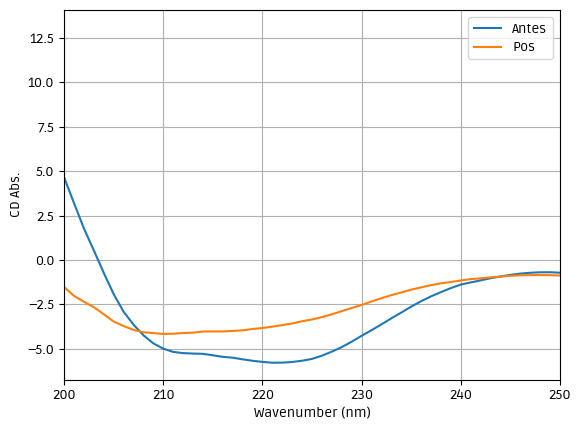

In [270]:
plt.plot(wl,cd_abs,label='Antes')
plt.plot(wl,cd_abs_pos,label='Pos')

plt.xlabel('Wavenumber (nm)'),plt.ylabel('CD Abs.')

plt.grid(),plt.legend(),plt.xlim(200,250)
plt.show()

In [253]:
len(cd_222_heat)

15

C:\Users\pedro220068\AppData\Local\Temp\ipykernel_25700\3871687876.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(25,100,5), cd_210_heat, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")
C:\Users\pedro220068\AppData\Local\Temp\ipykernel_25700\3871687876.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(25,100,5), cd_210_cool, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")


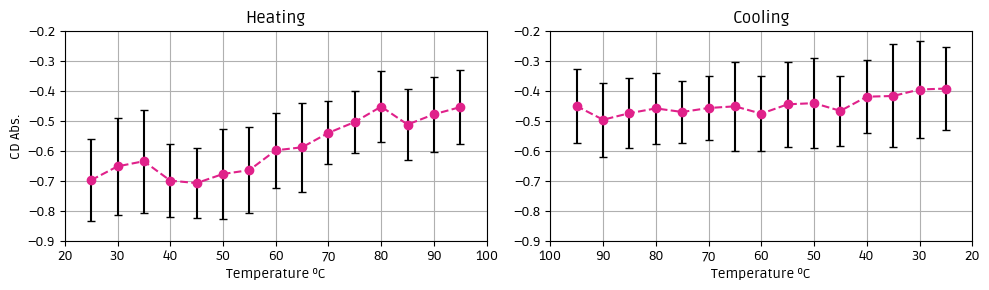

In [266]:
plt.figure(figsize=(10,3))

plt.subplot(121)
plt.errorbar(range(25,100,5), cd_210_heat, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")
plt.xlim(20,100),plt.ylim(-0.9,-0.2),plt.grid()

plt.title('Heating')
plt.xlabel('Temperature ºC'),plt.ylabel('CD Abs.')

plt.subplot(122)
plt.errorbar(range(25,100,5), cd_210_cool, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")
plt.xlim(100,20),plt.ylim(-0.9,-0.2),plt.grid()

plt.title('Cooling'),plt.xlabel('Temperature ºC')

plt.tight_layout()
plt.show()

C:\Users\pedro220068\AppData\Local\Temp\ipykernel_25700\1583901650.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(25,100,5), cd_222_heat, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")
C:\Users\pedro220068\AppData\Local\Temp\ipykernel_25700\1583901650.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(25,100,5), cd_222_cool, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")


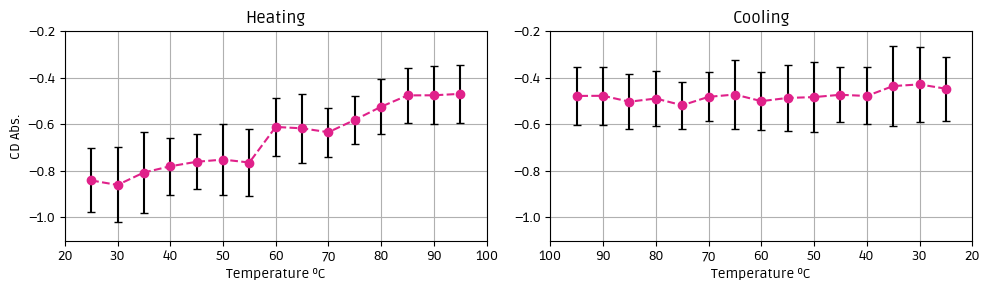

In [268]:
plt.figure(figsize=(10,3))

plt.subplot(121)
plt.errorbar(range(25,100,5), cd_222_heat, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")
plt.xlim(20,100),plt.ylim(-1.1,-0.2),plt.grid()

plt.title('Heating')
plt.xlabel('Temperature ºC'),plt.ylabel('CD Abs.')

plt.subplot(122)
plt.errorbar(range(25,100,5), cd_222_cool, yerr=error, capsize=3, fmt="r--o", color="#E0218A", ecolor = "black")
plt.xlim(100,20),plt.ylim(-1.1,-0.2),plt.grid()

plt.title('Cooling'),plt.xlabel('Temperature ºC')

plt.tight_layout()
plt.show()

Peso molecular 11.58 kDa

Testar afinidade antes e depois de aquecer

222, 210